## Import

In [6]:
import sys
sys.path.append(r'C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [7]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [18]:
import io
import copy
import pytz
import folium
import pyproj
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
import networkx as nx
from time import time
import geopandas as gpd
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import cartopy.io.img_tiles as cimgt
from shapely.geometry import MultiPoint
from urllib.request import urlopen, Request
from matplotlib.animation import FuncAnimation
from mongo_db import retrieve_database_and_collections
from networkx.drawing.nx_agraph import graphviz_layout
from convert_geometry import toMultiLineString, toExtremePoints
from log import print_INFO_message_timestamp, print_INFO_message
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString
from facility_location import AdjacencyMatrix, FacilityLocation, FacilityLocationReport

## Retrieve collection and convert to a dataframe

In [32]:
day = "20_04_2023"

In [33]:
def get_gdf(day):
    with open(rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\{day}_processed.geojson", "rb") as f:
        gdf = pkl.load(f)
    return gdf

In [34]:
gdf = get_gdf(day) 

### Take average value in each road segment for each gdf

In [328]:
gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))

In [329]:
gdf_line = gdf.set_geometry("geometry.multi_line")
gdf_point = gdf.set_geometry("geometry.extreme_point")

In [346]:
gdf_line_average = gdf_line.groupby(["description", "currentFlow.traversability", "geometry_length", "geometry.multi_line"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()

In [347]:
gdf_point_average = gdf_point.groupby(["description", "currentFlow.traversability", "geometry_length", "geometry.extreme_point"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()

##### Check for the presence of NaN values

In [349]:
gdf_line_average[gdf_line_average.isna().apply(lambda x: x["currentFlow.speedUncapped"], axis=1)]

Empty DataFrame
Columns: [description, currentFlow.traversability, geometry_length, geometry.multi_line, length, currentFlow.speed, currentFlow.speedUncapped, currentFlow.freeFlow, currentFlow.jamFactor, currentFlow.confidence]
Index: []

##### Delete NaN values

In [338]:
gdf_line_average.dropna(subset=["currentFlow.speedUncapped"], inplace=True)

In [339]:
gdf_line_average[gdf_line_average.isna().apply(lambda x: x["currentFlow.speedUncapped"], axis=1)]

Empty DataFrame
Columns: [description, geometry_length, geometry.multi_line, length, currentFlow.speed, currentFlow.speedUncapped, currentFlow.freeFlow, currentFlow.jamFactor, currentFlow.confidence]
Index: []

### Visualize the data

In [350]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [351]:
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [308]:
osm_img.crs

<Bound CRS: +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@nu ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [352]:
def get_color(jam, traversability):
    if jam is np.nan:
        return np.nan
    
    if traversability == "closed":
        return "black"
    
    if 0 <= jam <= 3:
        return "green"
    elif 3 < jam <= 7:
        return "orange"
    elif 7 <= jam <= 10:
        return "red"

In [353]:
lats = {}
lons = {}
df_list = []
    
for feature, jam, traversability in zip(gdf_line_average['geometry.multi_line'], gdf_line_average["currentFlow.jamFactor"], gdf_line_average["currentFlow.traversability"]):
    color = get_color(jam, traversability)
    linestrings = feature.geoms
    lats = []
    lons = []
    colors = []
        
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, list(x))
        lons = np.append(lons, list(y))
        colors = np.append(colors, [color]*len(x))
        
    df_list.append(pd.DataFrame({"lat": lats, "lon": lons, "color": colors}))
    df_list[-1] = pd.concat([df_list[-1], 
                                       pd.DataFrame({"lat": [np.nan], "lon": [np.nan], "color": [np.nan]})],
                                      ignore_index=True)

df = pd.concat(df_list, ignore_index=True)

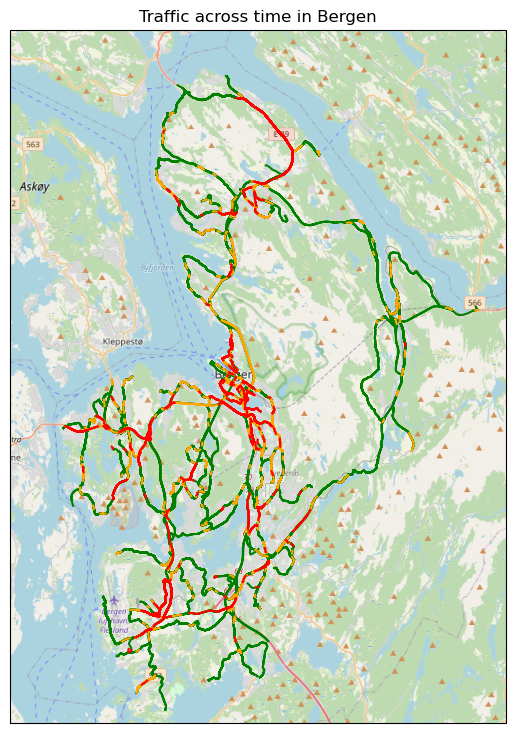

In [354]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

ax.set_title('Traffic across time in Bergen')

ax.plot('lat', 'lon', data=df.where(df.color=="green"), c="green", transform=ccrs.Geodetic())
ax.plot('lat', 'lon', data=df.where(df.color=="orange"), c="orange", transform=ccrs.Geodetic())
ax.plot('lat', 'lon', data=df.where(df.color=="red"), c="red", transform=ccrs.Geodetic())

## Build average graph

In [358]:
mapping = {}

for i, col in enumerate(gdf_point_average.columns):
    mapping[col] = i

In [359]:
G = nx.DiGraph()

for row in gdf_point_average.values:
    p0 = row[mapping["geometry.extreme_point"]][0]
    p1 = row[mapping["geometry.extreme_point"]][1]
    t0 = tuple([p0.coords.xy[0][0], p0.coords.xy[1][0]])
    t1 = tuple([p1.coords.xy[0][0], p1.coords.xy[1][0]])
    speed = row[mapping["currentFlow.speedUncapped"]]
    length = row[mapping["length"]]
    description = row[mapping["description"]]
    
    G.add_edge(t0, t1, weight=speed, length=length, description=description)

In [360]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
pos = {node : transformer.transform(node[1], node[0]) for node in G.nodes()}

Text(0.5, 1.0, 'Bergen road network')

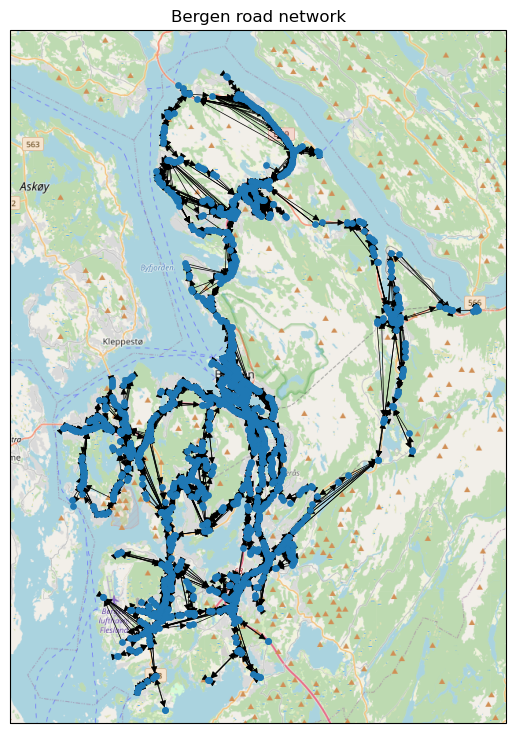

In [361]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

nx.draw_networkx(G, pos=pos, 
                 node_size=15,
                 ax=ax,
                 width=0.5,
                 arrows=True,
                 with_labels = False)

ax.set_title('Bergen road network')


#### Weak connection

In [362]:
nx.number_weakly_connected_components(G)

46

In [364]:
weakly_cc =  [c for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]

In [365]:
CC = []
for cc in weakly_cc:
    nodes = [tuple([node[0], node[1]]) for node in cc]
    CC.append(nx.DiGraph())
    for node1 in nodes:
        for node2 in nodes:
            if G.has_edge(node1, node2):
                CC[-1].add_edge(node1, node2)

In [366]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
positions = []
for cc in CC:
    try:
        positions.append({node : transformer.transform(node[1], node[0]) for node in cc.nodes()})
    except:
        print(cc.nodes())

In [367]:
n = 0
l = []
for i, cc in enumerate(CC):
    n+= len(cc.nodes())
    l.append(n/sum([len(cc.nodes()) for cc in CC]))

Text(0, 0.5, 'Fraction of nodes')

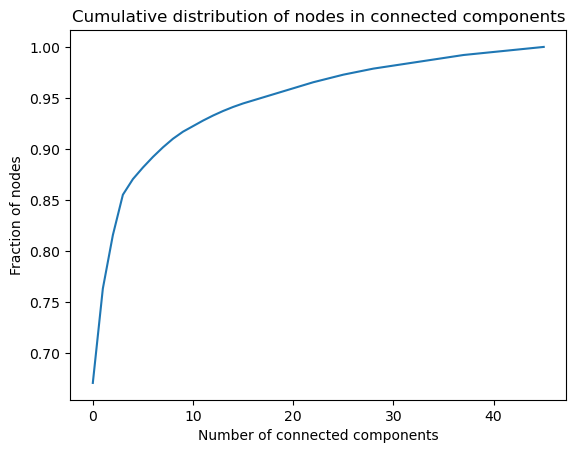

In [368]:
plt.plot(l)
plt.title("Cumulative distribution of nodes in connected components")
plt.xlabel("Number of connected components")
plt.ylabel("Fraction of nodes")

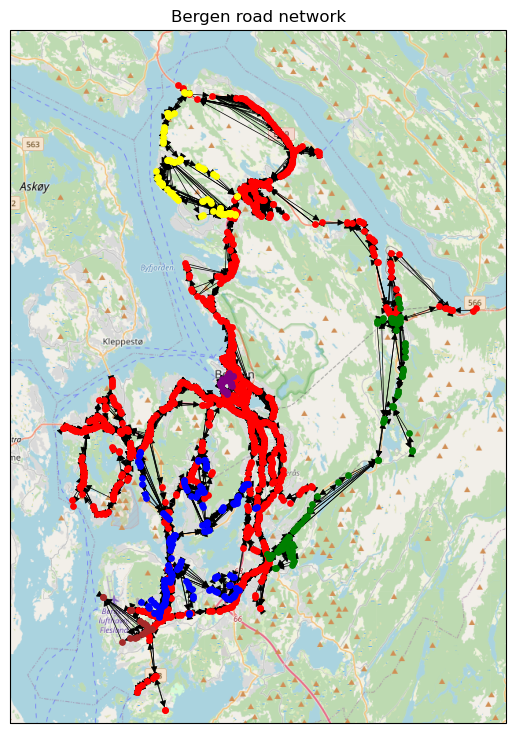

In [369]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

ax.set_title('Bergen road network')

colors = ["red", "blue", "green", "yellow", "purple", "brown"]
n = len(colors)

for cc, pos, col in zip(CC[:n], positions[:n], colors[:n]):
    nx.draw_networkx(cc, pos=pos, 
                 node_size=15,
                 ax=ax,
                 width=0.5,
                 arrows=True,
                 node_color=col,
                 with_labels = False)

In [373]:
# OpenStreetMap
map = folium.Map(location=center_pt, tiles="OpenStreetMap", zoom_start=11)
n=5
for cc, pos, col in zip(CC[:n], positions[:n], colors[:n]):
    for node in cc.nodes():
        folium.Circle([node[1], node[0]], radius=1, color=col).add_to(map)
    
    for edge in cc.edges():
        for i, e in enumerate(gdf_point_average["geometry.extreme_point"]):
            if e == MultiPoint(edge):
                multi_line = gdf_line_average.iloc[i]["geometry.multi_line"].geoms
                folium_coords = []
                for line in multi_line:
                    coords = line.coords.xy
                    folium_coords += [tuple([coords[1][0], coords[0][0]]), tuple([coords[1][-1], coords[0][-1]])] 
                folium.PolyLine(folium_coords, weight=1, color=col).add_to(map)
map

KeyboardInterrupt: 

### Strong connection

In [390]:
nx.number_strongly_connected_components(G)

457

In [391]:
strongly_cc =  [c for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]

In [392]:
CC = []
print_INFO_message_timestamp("Creating connected components")
for cc in strongly_cc:
    print_INFO_message("{} out of {} with nodes {}".format(len(CC)+1, len(strongly_cc), len(cc)))
    CC.append(nx.DiGraph())
    for i, node1 in enumerate(cc):
        for node2 in cc:
            if G.has_edge(node1, node2):
                edge_data = G.get_edge_data(node1, node2)
                CC[-1].add_edge(node1, node2, weight=edge_data["weight"], description=edge_data["description"])

[05/09/23 13:41:38] INFO     Creating connected components
                    INFO     1 out of 457 with nodes 984
                    INFO     2 out of 457 with nodes 137
                    INFO     3 out of 457 with nodes 80
                    INFO     4 out of 457 with nodes 74
                    INFO     5 out of 457 with nodes 62
                    INFO     6 out of 457 with nodes 23
                    INFO     7 out of 457 with nodes 20
                    INFO     8 out of 457 with nodes 18
                    INFO     9 out of 457 with nodes 17
                    INFO     10 out of 457 with nodes 15
                    INFO     11 out of 457 with nodes 14
                    INFO     12 out of 457 with nodes 14
                    INFO     13 out of 457 with nodes 13
                    INFO     14 out of 457 with nodes 12
                    INFO     15 out of 457 with nodes 11
                    INFO     16 out of 457 with nodes 11
                    INFO     17 out 

In [393]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
positions = []
for cc in CC:
    try:
        positions.append({node : transformer.transform(node[1], node[0]) for node in cc.nodes()})
    except:
        print(cc.nodes())

In [394]:
n = 0
l = []
for i, cc in enumerate(CC):
    n+= len(cc.nodes())
    l.append(n/sum([len(cc.nodes()) for cc in CC]))

Text(0, 0.5, 'Fraction of nodes')

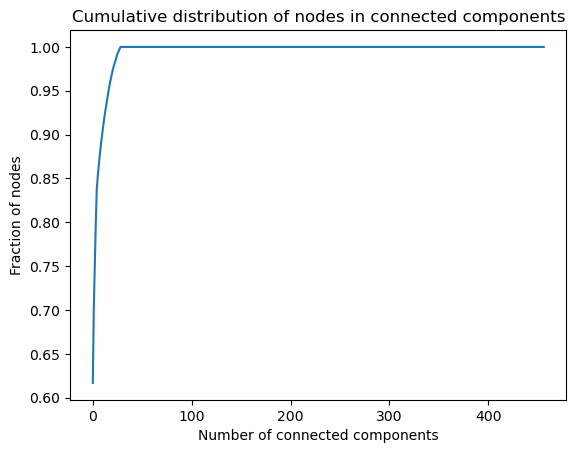

In [395]:
plt.plot(l)
plt.title("Cumulative distribution of nodes in connected components")
plt.xlabel("Number of connected components")
plt.ylabel("Fraction of nodes")

In [396]:
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey", "black"]

In [398]:
# OpenStreetMap
map = folium.Map(location=center_pt, tiles="OpenStreetMap", zoom_start=11)
n = len(colors)
for i, (cc, pos, col) in enumerate(zip(CC[:n], positions[:n], colors[:n])):
    for node in cc.nodes():
        folium.Circle([node[1], node[0]], radius=1, color=col).add_to(map)
    
    if i != 0:
        for edge in cc.edges():
            for i, e in enumerate(gdf_line_average["geometry.multi_line"]):
                if e.contains(LineString(edge)):
                    multi_line = gdf_line_average.iloc[i]["geometry.multi_line"].geoms
                    folium_coords = []
                    for line in multi_line:
                        coords = line.coords.xy
                        folium_coords += [tuple([coords[1][0], coords[0][0]]), tuple([coords[1][-1], coords[0][-1]])] 
                    folium.PolyLine(folium_coords, weight=1, color=col).add_to(map)
map

### Working on connected components

In [377]:
def get_multi_line_from_edge(gdf_row, edge):
    if gdf_row[2] == MultiPoint(edge):
        return gdf_row[1]
    else:
        return None

In [378]:
def geodetic_distance_line(line, point):
    line_points = pd.Series([p for p in line.coords])
    for p1, p2 in zip(line_points, line_points):
        line_points.loc[len(line_points)] = pd.Series(LineString([p1, p2]).interpolate(0.5).coords[0])
    dis = line_points.apply(lambda x: geodesic(x, point.coords[0]).meters)
    return dis.min()

In [379]:
def geodetic_distance_multi_line(multi_line, point):
    multi_line_ = pd.Series(multi_line)
    dis = multi_line_.apply(lambda x: geodetic_distance_line(x, point))
    return dis.min()

In [387]:
def merge_ccs(cc1, cc2):
    print_INFO_message_timestamp("Merging connected components")
    nodes1 = pd.Series(list(cc1.nodes()))
    edges2 = pd.Series(list(cc2.edges()))
    intersection_nodes = []
    for i, edge in enumerate(edges2):
        print_INFO_message("Merging connected components: {}/{}".format(i+1, len(edges2)))
        try:
            multi_line = gdf_line_average.apply(lambda x: get_multi_line_from_edge(x, edge), axis=1).dropna().iloc[0]
            r = nodes1.apply(lambda x: multi_line.distance(Point(x)))
            if r.min() < 0.05:
                dis = geodetic_distance_multi_line(multi_line, Point(nodes1.iloc[r.idxmin()]))
            if dis < 15:
                intersection_nodes.append(r.idxmin())
                print_INFO_message("Merging connected components: distance = {}".format(dis))
        except:
            print(edge)
            
    return pd.Series(intersection_nodes).unique()

In [ ]:
intersection_nodes_01 = merge_ccs(CC[0], CC[1])

In [391]:
intersection_nodes_01

array([ 68,   7, 208, 136,   2,  62, 112], dtype=int64)

In [392]:
intersection_nodes_10 = merge_ccs(CC[1], CC[0])

[05/04/23 14:00:03] INFO     Merging connected components
                    INFO     Merging connected components: 1/293
                    INFO     Merging connected components: 2/293
                    INFO     Merging connected components: 3/293
                    INFO     Merging connected components: 4/293
                    INFO     Merging connected components: distance = 11.54751568764645
                    INFO     Merging connected components: 5/293
                    INFO     Merging connected components: 6/293
                    INFO     Merging connected components: 7/293
                    INFO     Merging connected components: 8/293
                    INFO     Merging connected components: 9/293
                    INFO     Merging connected components: 10/293
                    INFO     Merging connected components: 11/293
                    INFO     Merging connected components: 12/293
                    INFO     Merging connected components: distance = 0

In [394]:
intersection_nodes_10

array([23, 14, 29, 17, 16, 37], dtype=int64)

In [399]:
intersection_nodes = [intersection_nodes_01, []]

In [375]:
n = 0
m = 2

In [376]:
# OpenStreetMap
map = folium.Map(location=center_pt, tiles="OpenStreetMap", zoom_start=11)
for i, (cc, pos, col) in enumerate(zip(CC[n:m], positions[n:m], colors[n:m])):
    for j, node in enumerate(cc.nodes()):
        if j in intersection_nodes[i]:
            folium.Circle([node[1], node[0]], radius=2, color="black").add_to(map)
        else:
            folium.Circle([node[1], node[0]], radius=1, color=col).add_to(map)
    
    for edge in cc.edges():
        for i, e in enumerate(gdf_point_average["geometry.extreme_point"]):
            if e == MultiPoint(edge):
                multi_line = gdf_line_average.iloc[i]["geometry.multi_line"].geoms
                folium_coords = []
                for line in multi_line:
                    coords = line.coords.xy
                    folium_coords += [tuple([coords[1][0], coords[0][0]]), tuple([coords[1][-1], coords[0][-1]])] 
                folium.PolyLine(folium_coords, weight=1, smooth_factor=0, color=col).add_to(map)
map

NameError: name 'intersection_nodes' is not defined

## Build average graph v2

In [403]:
mapping = {}

for i, col in enumerate(gdf_line_average.columns):
    mapping[col] = i

In [407]:
G = nx.DiGraph()
for row in gdf_line_average.values:
    lines = pd.Series(row[mapping["geometry.multi_line"]])
    speed = row[mapping["currentFlow.speedUncapped"]]
    lengths = row[mapping["geometry_length"]]
    description = row[mapping["description"]]
    
    for i, line in enumerate(lines):
        p0 = toExtremePoints(line)[0]
        p1 = toExtremePoints(line)[-1]
        t0 = tuple([p0.coords.xy[0][0], p0.coords.xy[1][0]])
        t1 = tuple([p1.coords.xy[0][0], p1.coords.xy[1][0]])
        if speed == 0:
            G.add_edge(t0, t1, weight=100000, description=description)
        else:
            G.add_edge(t0, t1, weight=lengths[i]/speed, description=description)

In [406]:
# nea = 0
# ne = len(G.edges())
# print_INFO_message_timestamp("Adding edges")
# for edge in G.edges(data=True):
#     if not G.has_edge(edge[1], edge[0]):
#         nea += 1
#         G.add_edge(edge[1], edge[0], weight=edge[2]["weight"], description=edge[2]["description"])
# print_INFO_message("Number of edges added {} out of {}".format(nea, ne))

[05/09/23 13:48:52] INFO     Adding edges
                    INFO     Number of edges added 2159 out of 10451


In [408]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
pos = {node : transformer.transform(node[1], node[0]) for node in G.nodes()}

Text(0.5, 1.0, 'Bergen road network')

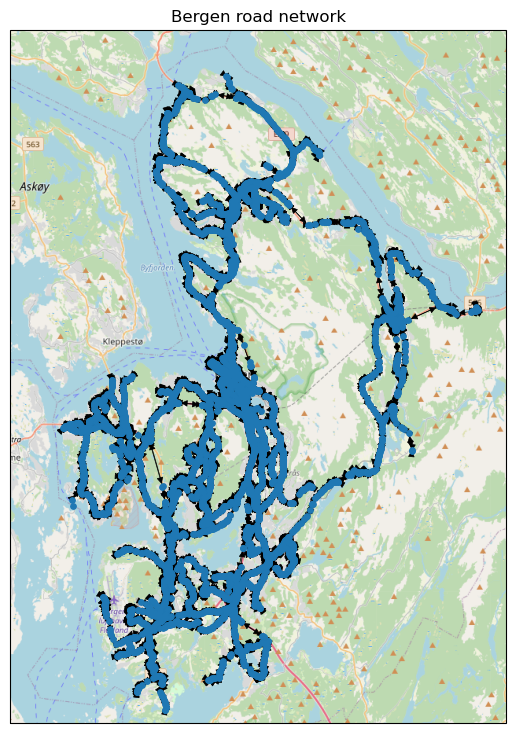

In [409]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

nx.draw_networkx(G, pos=pos, 
                 node_size=15,
                 ax=ax,
                 width=0.5,
                 arrows=True,
                 with_labels = False)

ax.set_title('Bergen road network')


#### Strong connection

In [410]:
nx.number_strongly_connected_components(G)

330

In [411]:
strongly_cc =  [c for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]

In [412]:
CC = []
print_INFO_message_timestamp("Creating connected components")
for cc in strongly_cc:
    print_INFO_message("{} out of {} with nodes {}".format(len(CC)+1, len(strongly_cc), len(cc)))
    CC.append(nx.DiGraph())
    for i, node1 in enumerate(cc):
        for node2 in cc:
            if G.has_edge(node1, node2):
                edge_data = G.get_edge_data(node1, node2)
                CC[-1].add_edge(node1, node2, weight=edge_data["weight"], description=edge_data["description"])

[05/09/23 13:50:43] INFO     Creating connected components
                    INFO     1 out of 330 with nodes 5608
                    INFO     2 out of 330 with nodes 70
                    INFO     3 out of 330 with nodes 19
                    INFO     4 out of 330 with nodes 17
                    INFO     5 out of 330 with nodes 4
                    INFO     6 out of 330 with nodes 4
                    INFO     7 out of 330 with nodes 3
                    INFO     8 out of 330 with nodes 1
                    INFO     9 out of 330 with nodes 1
                    INFO     10 out of 330 with nodes 1
                    INFO     11 out of 330 with nodes 1
                    INFO     12 out of 330 with nodes 1
                    INFO     13 out of 330 with nodes 1
                    INFO     14 out of 330 with nodes 1
                    INFO     15 out of 330 with nodes 1
                    INFO     16 out of 330 with nodes 1
                    INFO     17 out of 330 with 

In [413]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
positions = []
for cc in CC:
    try:
        positions.append({node : transformer.transform(node[1], node[0]) for node in cc.nodes()})
    except:
        print(cc.nodes())

In [414]:
n = 0
l = []
for i, cc in enumerate(CC):
    n+= len(cc.nodes())
    l.append(n/sum([len(cc.nodes()) for cc in CC]))

Text(0, 0.5, 'Fraction of nodes')

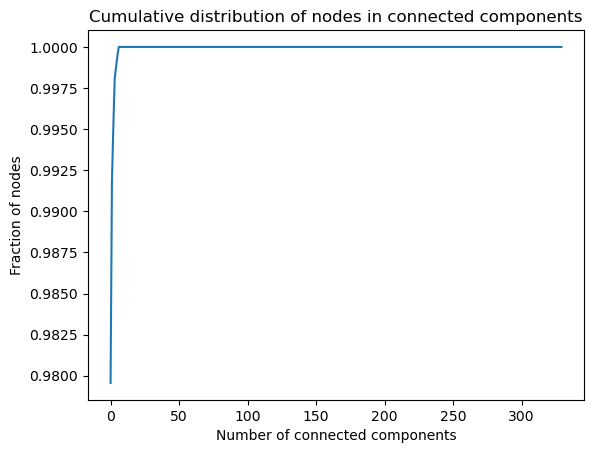

In [415]:
plt.plot(l)
plt.title("Cumulative distribution of nodes in connected components")
plt.xlabel("Number of connected components")
plt.ylabel("Fraction of nodes")

In [416]:
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey", "black"]

In [417]:
# OpenStreetMap
map = folium.Map(location=center_pt, tiles="OpenStreetMap", zoom_start=11)
n = len(colors)
for i, (cc, pos, col) in enumerate(zip(CC[:n], positions[:n], colors[:n])):
    for node in cc.nodes():
        folium.Circle([node[1], node[0]], radius=1, color=col).add_to(map)
    
    if i != 0:
        for edge in cc.edges():
            for i, e in enumerate(gdf_average["geometry.multi_line"]):
                if e.contains(LineString(edge)):
                    multi_line = gdf_average.iloc[i]["geometry.multi_line"].geoms
                    folium_coords = []
                    for line in multi_line:
                        coords = line.coords.xy
                        folium_coords += [tuple([coords[1][0], coords[0][0]]), tuple([coords[1][-1], coords[0][-1]])] 
                    folium.PolyLine(folium_coords, weight=1, color=col).add_to(map)
map

## Solve the facility location problem

### Take the biggest connected component

In [66]:
first_cc_of_G = copy.deepcopy(CC[0])

In [67]:
nx.is_strongly_connected(CC[0])

True

### Compute teh distance matrix

In [68]:
mapping = {}
for i, node in enumerate(first_cc_of_G.nodes()):
    mapping[i] = node

In [69]:
sp = dict(nx.all_pairs_dijkstra_path_length(first_cc_of_G))

In [70]:
distance_matrix = np.zeros((len(sp), len(sp)))

In [71]:
print_INFO_message_timestamp("Creating distance matrix")
for i in range(len((sp))):
    for j in range(len(sp)):
        distance_matrix[i,j] = sp[mapping[i]][mapping[j]]
    if i % 250 == 0:
        print_INFO_message("{} out of {}".format(i, len(sp)))

[05/08/23 12:00:43] INFO     Creating distance matrix
                    INFO     0 out of 5958
                    INFO     250 out of 5958
                    INFO     500 out of 5958
                    INFO     750 out of 5958
                    INFO     1000 out of 5958
                    INFO     1250 out of 5958
                    INFO     1500 out of 5958
                    INFO     1750 out of 5958
                    INFO     2000 out of 5958
                    INFO     2250 out of 5958
                    INFO     2500 out of 5958
                    INFO     2750 out of 5958
                    INFO     3000 out of 5958
                    INFO     3250 out of 5958
                    INFO     3500 out of 5958
                    INFO     3750 out of 5958
                    INFO     4000 out of 5958
                    INFO     4250 out of 5958
                    INFO     4500 out of 5958
                    INFO     4750 out of 5958
                    INFO     500

### Problem definition

In [72]:
weighted_adj_matrix = AdjacencyMatrix(adj_matrix=distance_matrix, 
                                  kind="empirical",
                                  epsg=None,
                                  mode="time")

In [73]:
coordinates = pd.Series(list(first_cc_of_G.nodes()))
coordinates = coordinates.apply(lambda x: Point(x))
coordinates = gpd.GeoDataFrame(geometry=coordinates)

In [74]:
n_locations_to_choose = 3

In [75]:
fl_exact = FacilityLocation(coordinates, n_locations_to_choose, weighted_adj_matrix)
fl_gon = FacilityLocation(coordinates, n_locations_to_choose, weighted_adj_matrix)
fl_gon_plus = FacilityLocation(coordinates, n_locations_to_choose, weighted_adj_matrix)

### Solve the problem

#### Simple Gon

In [76]:
fl_gon.solve(mode = "approx")

In [77]:
fl_gon.solution_value

1581.0102393685734

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

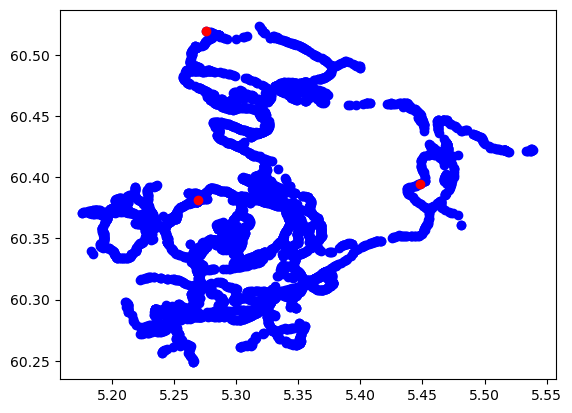

In [78]:
fl_gon.plot()

#### Gon+

In [79]:
fl_gon_plus.solve(mode = "approx", algorithm = "gon_plus", n_trial = len(coordinates))

In [80]:
fl_gon_plus.solution_value

1247.4562718663813

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

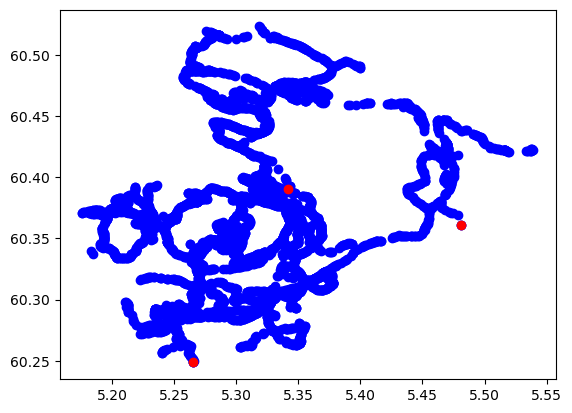

In [81]:
fl_gon_plus.plot()

#### Exact 

In [48]:
fl_exact.solve(mode = "exact")

[05/07/23 12:31:17] ERROR    Constructing component 'maximalDistance' from data=None failed:      ]8;id=413572;file://c:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\pyomo\core\base\PyomoModel.py\PyomoModel.py]8;;\:]8;id=157858;file://c:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\pyomo\core\base\PyomoModel.py#828\828]8;;\
                                 KeyboardInterrupt:                                                                

: 

In [ ]:
fl_exact.solution_value

In [ ]:
fl_exact.plot()